In [ ]:
import numpy as np
import matplotlib.pyplot as plt

signal = np.load('../fragments2/1123_1.npy')

# 执行傅里叶变换
n = len(signal)  # 信号长度
f = np.fft.fftfreq(n, 1/fs)  # 频率向量
F = np.fft.fft(signal)  # 快速傅里叶变换

# 绘制频谱图
plt.figure(figsize=(10, 4))
plt.stem(f[:n // 2], np.abs(F[:n // 2]) * 2 / n)  # 仅绘制正频率部分
plt.ylim((0,2))
plt.title('Frequency spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# The PRSA curve

In [5]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import decimate
import numpy as np
import matplotlib.pyplot as plt
from ssqueezepy import Wavelet, cwt

def find_deceleration_anchor_points(fhr_series, T):
    dec_points = []
    for t in range(T, len(fhr_series) - T):
        if np.mean(fhr_series[t:t+T]) > np.mean(fhr_series[t-T:t]):
            dec_points.append(t)
            
    print('num: dec points:', len(dec_points))
    return dec_points

def bpm_to_ms(bpm):
    return 60000 / bpm

def generate_prsa_curve(fhr_series, L, T, sampling_rate):
    overall_mean = np.mean(fhr_series)
    
    dec_points = find_deceleration_anchor_points(fhr_series, T)
    prsa_curves = []
    
    for dec in dec_points:
        if dec - L >= 0 and dec + L < len(fhr_series):
            window = [fhr_series[x] for x in range(dec-L, dec+L)]
            window_relative = window - overall_mean  # 计算相对变化
            prsa_curves.append(window_relative)
    
    if prsa_curves:
        prsa_curve = np.mean(prsa_curves, axis=0)
        time_axis = np.linspace(-L/sampling_rate, L/sampling_rate, num=2*L)
        return time_axis, prsa_curve
    else:
        return [], []
    



# The PRSA spectrum

In [ ]:
def prsa_spectrum(fhr_series):
    fhr_series_ms = bpm_to_ms(fhr_series)
    time_axis, prsa_curve = generate_prsa_curve(fhr_series_ms, L, T, smaple_rate)


    prsa_data = prsa_curve
    fs = 4 #sample rate
    t = np.linspace(0, len(prsa_data) / fs, num=len(prsa_data), endpoint=False)

    # Morse wavelet 
    gamma = 3
    # based on the time-bandwidth product equal to 60 in the paper
    # beta = gamma * time-bandwidth product
    beta = 180
    wavelet = Wavelet(('gmw', {'gamma': gamma, 'beta': beta}))

    # cwt 
    Wx, scales = cwt(prsa_data, wavelet)
    print("Wx:", Wx)
    print("scales:", scales)

    # wavelet power
    spectrogram = np.abs(Wx)**2


    sampling_period = 1 / fs
    #frequencies = (beta ** (1 / gamma)) / (np.sqrt(2 * np.pi) * scales * sampling_period)
    frequencies = ((2**(1/beta)) * ((gamma/beta)**(1/gamma))) / (scales * fs)

    # when k = 0, central freq spectrogram 
    central_freq_index = len(prsa_data) // 2  # 中心频率索引
    PRSA_Spt = spectrogram[:, central_freq_index]

    
    # plot original signal
    plt.figure(figsize=(10,4))
    plt.plot(fhr_series_ms)
    plt.title('Original FHR signal')
    plt.xlabel('Time[samples]')
    plt.ylabel('[ms]')

    #plot prsa curve
    plt.show()
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, prsa_curve)
    plt.title('The PRSA curve')
    plt.xlabel('k[s]')
    plt.ylabel('[ms]')
    plt.show()

    # plot cwt spectrogram 
    plt.figure(figsize=(10, 4))
    plt.imshow(np.log1p(spectrogram), aspect='auto', extent=[t[0], t[-1], frequencies[-1], frequencies[0]],
               interpolation='nearest', cmap='viridis', origin='lower')
    plt.colorbar(label='Log-Scaled Power')
    plt.title('CWT Spectrogram of the PRSA Curve')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

    # plot cwt spectrum at k=0
    plt.figure(figsize=(10, 4))
    plt.plot(frequencies, PRSA_Spt)
    #plt.xlim((0,1))
    plt.title('CWT Spectrum at k=0')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Wavelet Power')
    plt.gca().invert_yaxis()  # 反转 Y 轴以匹配小波尺度的通常显示方式
    plt.grid(True)
    plt.show()
    
    return frequencies, spectrogram


L = 100
T = 1
smaple_rate = 2

# compute the prsa curve
fhr_series = np.load('../fragments2/1123_1.npy')
fhr_series_downsampled = decimate(fhr_series, q=2, n=None, ftype='iir', axis=-1, zero_phase=True)

frequencies, spectrogram = prsa_spectrum(fhr_series_downsampled)


# Other wavelet

In [6]:
import pywt
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from scipy.signal import decimate
from ssqueezepy import Wavelet, cwt

def plot_wavelet_transform(data):
    
    # generate prsa_curve
    L = 100
    T = 1
    sample_rate = 2
    time_axis, prsa_curve = generate_prsa_curve(data, L, T, sample_rate)
    print(prsa_curve.shape)
    # compute scales 
    N = len(prsa_curve)          # 信号长度，例如1024个数据点
    delta_t = 0.5      # 采样周期，以秒为单位
    s0 = 1.0           # 初始尺度，1秒（2 * delta_t）
    J = 179          # 尺度总数
    delta_j = 1 / J * np.log2(N * delta_t / s0)
    scales = s0 * 2 ** (np.arange(0, J + 1) * delta_j)
    time = np.linspace(0, 1, N)
    
    # 进行连续小波变换
    wavename = 'cmor'
    central_frequency = 6
    bandwidth = 1.5  # 这是Morlet小波的典型带宽参数

    wavelet = pywt.ContinuousWavelet(wavename + str(bandwidth) + '-' + str(central_frequency))
    coefficients, frequencies = pywt.cwt(prsa_curve, scales, wavelet, sampling_period=1/sample_rate)

    spectrogram = np.abs(coefficients)
    
    central_freq_index = len(prsa_curve) // 2  # 中心频率索引
    PRSA_Spt = spectrogram[:, central_freq_index]
    
    

    
    
    plt.figure(figsize=(5, 3), dpi=300)
    plt.imshow(np.abs(coefficients), extent=[time[0], time[-1], scales[-1], scales[0]], cmap='gray', aspect='auto')
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Scales')
    plt.title('Continuous Wavelet Transform (CWT) of PRSA Data')
    plt.show()
    
    '''
    # plot cwt spectrum at k=0
    plt.figure(figsize=(5, 3))
    plt.plot(frequencies, PRSA_Spt)
    #plt.xlim((0,1))
    plt.title('CWT Spectrum at k=0')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Wavelet Power')
    plt.gca().invert_yaxis()  # 反转 Y 轴以匹配小波尺度的通常显示方式
    plt.grid(True)
    plt.show() 
    '''

    
    return spectrogram
    




'''
fhr_signals = [file for file in os.listdir('../fragments2') if file.endswith('.npy')]
for file in fhr_signals:
    fhr_series = np.load(os.path.join('../fragments2', file))
    fhr_series_downsampled = decimate(fhr_series, q=2, n=None, ftype='iir', axis=-1, zero_phase=True)
    spectrogram = plot_wavelet_transform(fhr_series_downsampled)
    save_path = os.path.join('../spectrograms', file)
    np.save(save_path, spectrogram)

'''


"\nfhr_signals = [file for file in os.listdir('../fragments2') if file.endswith('.npy')]\nfor file in fhr_signals:\n    fhr_series = np.load(os.path.join('../fragments2', file))\n    fhr_series_downsampled = decimate(fhr_series, q=2, n=None, ftype='iir', axis=-1, zero_phase=True)\n    spectrogram = plot_wavelet_transform(fhr_series_downsampled)\n    save_path = os.path.join('../spectrograms', file)\n    np.save(save_path, spectrogram)\n\n"

num: dec points: 1295
(200,)


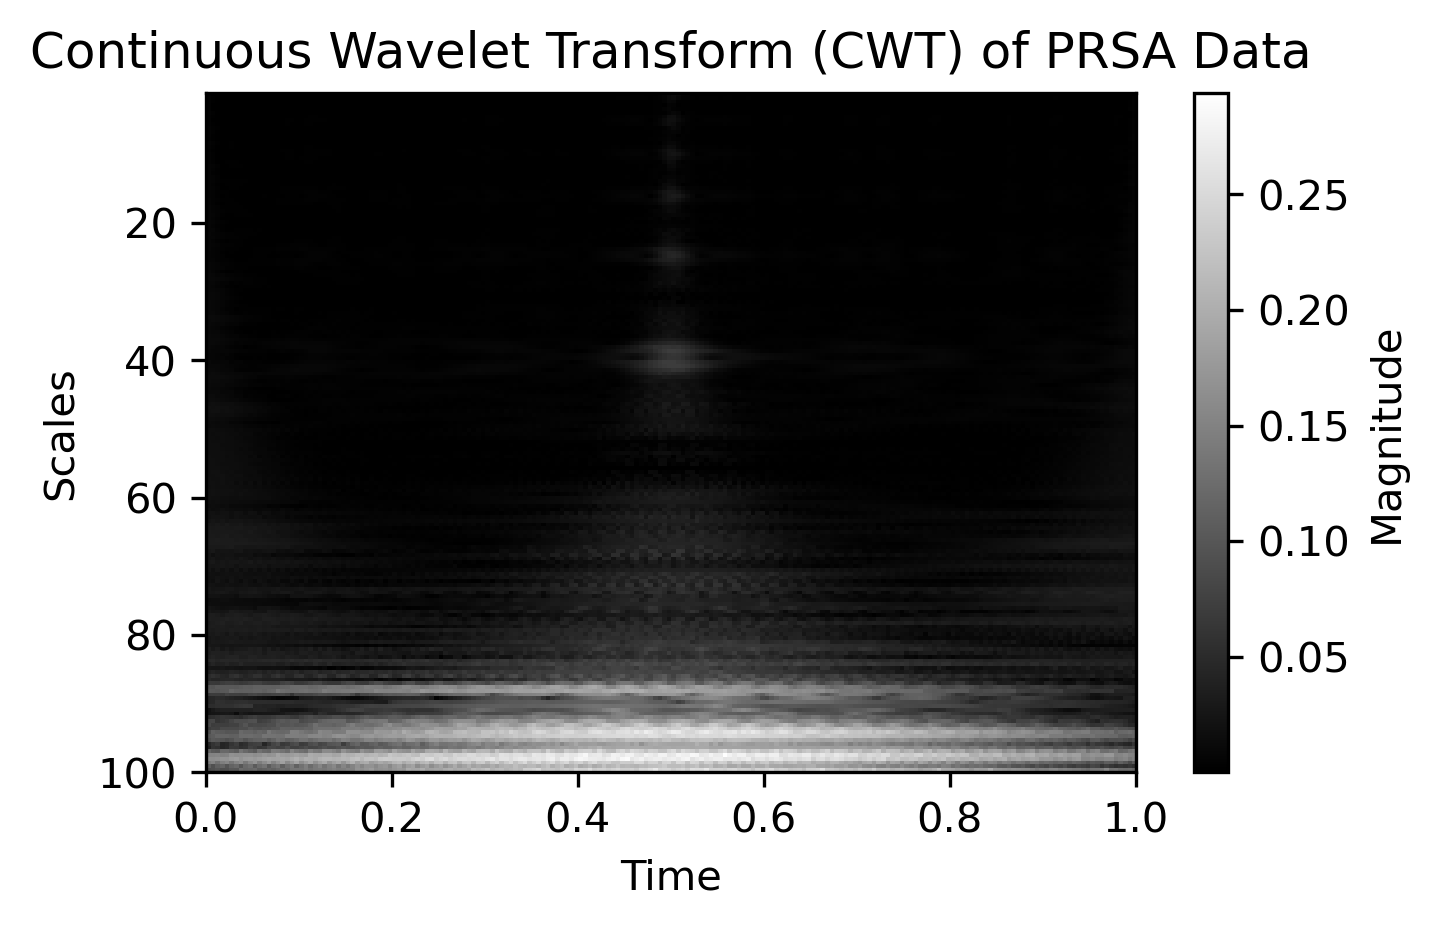

(180, 200)

In [8]:
fhr_series = np.load(os.path.join('../1-data/1-generation/training/1123_1.npy'))
fhr_series_downsampled = decimate(fhr_series, q=2, n=None, ftype='iir', axis=-1, zero_phase=True)
spectrogram = plot_wavelet_transform(fhr_series_downsampled)
spectrogram.shape

num: dec points: 1295
[-0.3744868  -0.33244535 -0.3012553  -0.29691599 -0.28455665 -0.21897868
 -0.21658512 -0.27004139 -0.25632804 -0.24231509 -0.25514616 -0.22135241
 -0.19249111 -0.18718184 -0.16520237 -0.16247909 -0.17634276 -0.21221304
 -0.26839911 -0.2944231  -0.30697601 -0.2826758  -0.21606599 -0.16342278
 -0.12382728 -0.09467104 -0.05620056 -0.01309389 -0.02119878 -0.06383249
 -0.0762255  -0.08266438 -0.10437181 -0.09177118 -0.08878627 -0.12177461
 -0.14838431 -0.17536671 -0.19811681 -0.22002354 -0.24110641 -0.23274388
 -0.18590354 -0.14676805 -0.15014611 -0.1519539  -0.15179882 -0.16263577
 -0.16900416 -0.17796985 -0.16198766 -0.12070299 -0.09660443 -0.10611944
 -0.13615814 -0.16806377 -0.21075505 -0.2360162  -0.25210096 -0.28316042
 -0.24740035 -0.18337496 -0.141075   -0.08571131 -0.06169547 -0.03716517
 -0.02237309 -0.04292347 -0.0642909  -0.10968062 -0.12686483 -0.16062414
 -0.20730154 -0.17718458 -0.1899038  -0.23607547 -0.25455512 -0.28945297
 -0.31551212 -0.32674278 -0.3

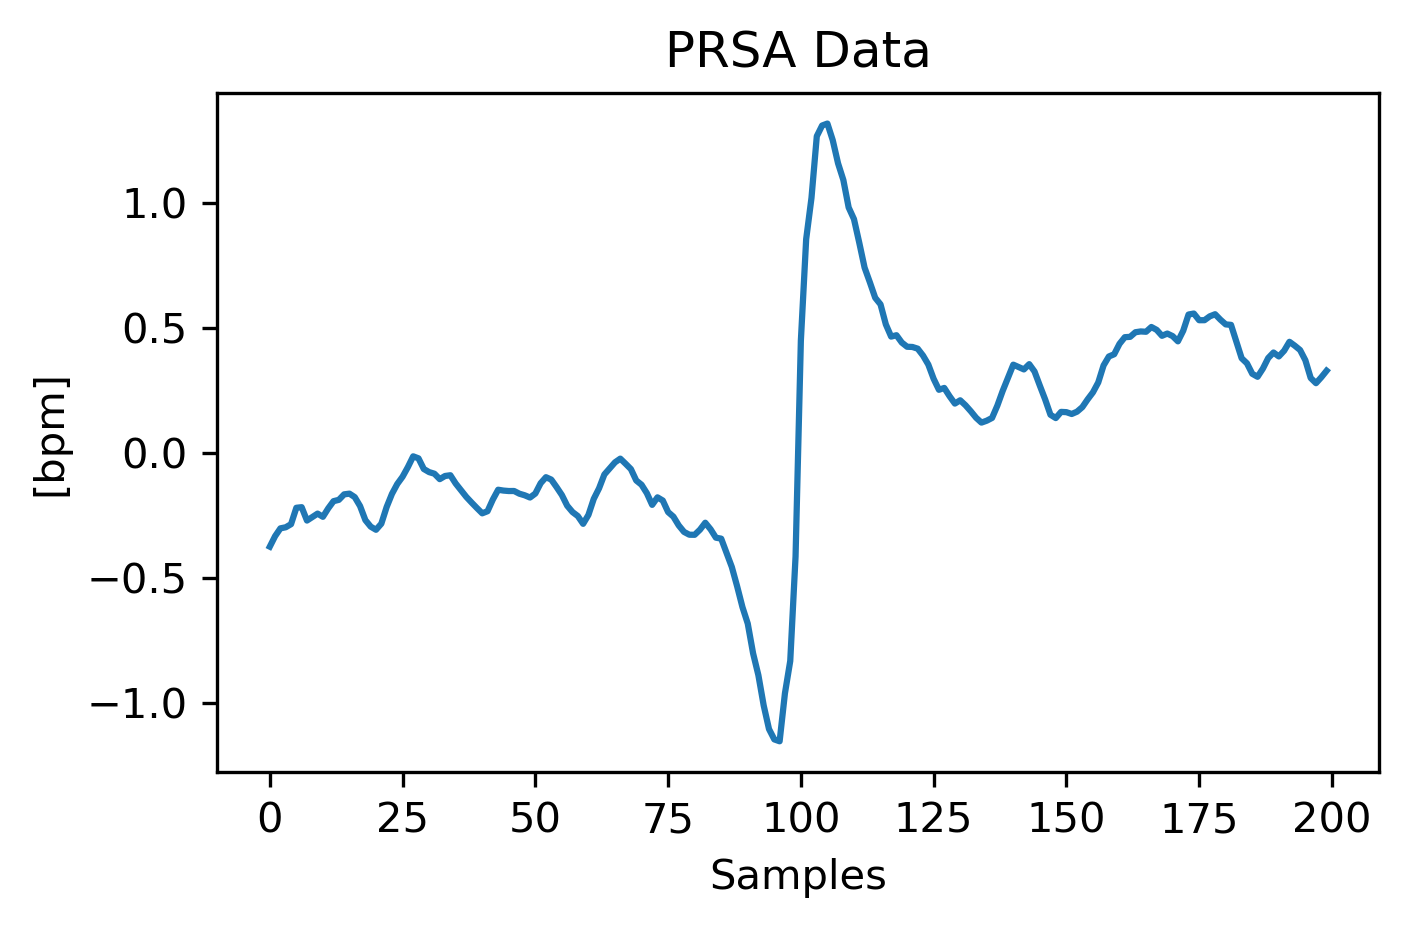

In [10]:
import os

L = 100
T = 1
sample_rate = 2
fhr_series = np.load(os.path.join('../1-data/1-generation/training/1123_1.npy'))
fhr_series_downsampled = decimate(fhr_series, q=2, n=None, ftype='iir', axis=-1, zero_phase=True)
_, prsa_curve = generate_prsa_curve(fhr_series_downsampled, L, T, sample_rate)
print(prsa_curve)

plt.figure(figsize=(5, 3), dpi=300)
plt.plot(prsa_curve)
plt.xlabel('Samples')
plt.ylabel('[bpm]')
plt.title('PRSA Data')
plt.show()